In [ ]:
!mkdir -p data/

# Download images and labels from Duke Box, and then unzip them
!wget -nc -O data/images.zip https://duke.box.com/shared/static/rttn4ujt4h9sbuba4poibdvtlqr7fhvz.zip
!wget -nc -O data/labels.zip https://duke.box.com/shared/static/psea4em0oh1ng99neowslj9hfz79sckn.zip

!unzip -n -q data/images.zip -d data
!unzip -n -q data/labels.zip -d data

In [3]:
def get_state(name):
    return name.split('_')[2]

def get_region(name):
    state = get_state(name)
    for key, val in regions.items():
        if state in val:
            return key

regions = {'SW' : ['CA', 'AZ', 'TX', 'NM', 'NV', 'UT', 'CO'], 
              'NE': ['VT', 'MD', 'ME', 'NH', 'PA', 'NJ', 'NY', 'MA', 'DE'],
              'NW': ['WA', 'ID', 'OR', 'MT'],
              'EM': ['MI', 'MN', 'MO', 'WI', 'IN', 'IA', 'IL', 'OH'],
              'WM': ['ND', 'OK', 'KS', 'SD', 'NE']}

924
Number of small turbines: 49
Total number of wind Turbines: 1594


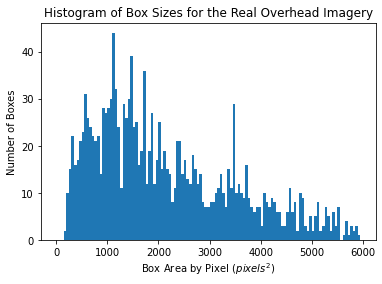

In [18]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Get all of the label paths
label_paths = glob.glob('data/labels/*.txt')
naip_paths = [path for path in label_paths if path.split('/')[-1].split('.')[0].split('_')[0] == 'naip']
non_naip_paths = [path for path in label_paths if path.split('/')[-1].split('.')[0].split('_')[0] != 'naip']
non_SW_paths = [path for path in naip_paths if get_region(path.split('/')[-1]) != 'SW']
label_paths = non_SW_paths + non_naip_paths

print(len(label_paths))

# List to store all of the box sizes
boxes=[]

# If the pixel area of a box is below the threshold, we count it as a small turbine
threshold = 350

small_turbines = 0
count = 0

# Loop through labels and turbines in each label, counting number of small turbines
for label_path in label_paths:
    label = open(label_path, 'r')
    for line in label:
        count+=1
        height=float(line.split(" ")[-2]) * 608
        width=float(line.split(" ")[-1]) * 608
        area=height*width
        if area < threshold:
          small_turbines+=1
        boxes.append(area)

print(f"Number of small turbines: {small_turbines}")
print("Total number of wind Turbines: {}".format(count))
 
# Plot histogram
bins = np.arange(0, 6000, 50)
fig,ax=plt.subplots(num=2)
ax = plt.hist(boxes, bins)
plt.xlabel(r"Box Area by Pixel $(pixels^2)$")
plt.ylabel("Number of Boxes")
plt.title("Histogram of Box Sizes for the Real Overhead Imagery")
fig.savefig("turbine_sizes_real.png")

# Sort the boxes and write to a file for the raw data
boxes.sort()
with open('bboxes_sizes.txt', 'w') as f:
  f.writelines(['%s\n' % round(box) for box in boxes])

In [ ]:
# Get a specific image and display the bbox sizes for a visual reference of turbine size
import cv2
from google.colab.patches import cv2_imshow

image_paths = glob.glob('data/images/*.jpg')
label_paths = glob.glob('data/labels/*.txt')

example_img_path = 'data/images/naip_1434_CA_WND_i1j0.jpg'
example_label_path = 'data/labels/naip_1434_CA_WND_i1j0.txt'

label = open(example_label_path, 'r')

boxes=[]
for line in label:
  height=float(line.split(" ")[-2]) * 608
  width=float(line.split(" ")[-1]) * 608
  area=height*width
  boxes.append(area)
print("Areas of the ground truth label boxes in the image:")
print(boxes)

img = cv2.imread(example_img_path)
cv2_imshow(img)

In [ ]:
# Make new labels, replacing the class with a 1 if the turbine has a bbox size less than the threshold
!mkdir labels

label_paths=glob.glob('data/labels/*.txt')
threshold = 350

for label_path in label_paths:
    label = open(label_path, 'r')
    label_id = label_path.split('/')[-1]

    new_label = open('labels/{}'.format(label_id), 'w')

    for line in label:
        count+=1
        height=float(line.split(" ")[-2]) * 608
        width=float(line.split(" ")[-1]) * 608
        area=height*width

        if area < threshold:
          end = line[2:]
          line = "1 " + end
        new_label.write(line)

    label.close()
        

In [ ]:
!zip -r -q labels.zip labels

In [ ]:
#!rm -rf new_labels